In [167]:
import os

import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image
from sam2.build_sam import build_sam2
import sam2
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator
from sam2.sam2_image_predictor import SAM2ImagePredictor

from tqdm import tqdm
import json
import numpy as np
from pycocotools.mask import decode
import cv2 

np.random.seed(3)


sam2_checkpoint = "/home/user/sam2/checkpoints/sam2.1_hiera_small.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_s.yaml"
sam2 = build_sam2(model_cfg, sam2_checkpoint, device='cuda', apply_postprocessing=False)


mode = 'coco_rle'


mask_generator = SAM2AutomaticMaskGenerator(
model=sam2,
points_per_side=32,
points_per_batch=128,
pred_iou_thresh=0.5,
stability_score_thresh=0.92,
stability_score_offset=0.7,
crop_nms_thresh = 0.7,
crop_n_layers=4,
box_nms_thresh=0.4,
crop_n_points_downscale_factor=2,
min_mask_region_area=5.0,
crop_overlap_ratio= 1000 / 1500,
# use_m2m=True,
output_mode = mode,
)# Create prompt for segmenting all cheese

# bounding_box = np.array([20, 10, 135, 230])

In [168]:
sam2_checkpoint = "/home/user/sam2/checkpoints/sam2.1_hiera_small.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_s.yaml"

sam2_model = build_sam2(model_cfg, sam2_checkpoint, device="cuda")

predictor = SAM2ImagePredictor(sam2_model)

In [169]:
# Helper functions

def remove_noisy_mask(masks):
    area_min = 7000
    area_min = 9000
    area_diff_min = 1000000
    selected_mask = None

    # for i in range(len(masks)):
    #     rle_annotation = masks[i]['segmentation']
    #     area = masks[i]['area']

    #     area_diff = abs(area - area_gt)
    #     if area_diff < area_diff_min:
    #         selected_mask = decode(rle_annotation)
    #         area_diff_min = area_diff


def select_bread_mask(masks):
    area_gt = 7500
    area_diff_min = 1000000
    selected_mask = None

    for i in range(len(masks)):
        rle_annotation = masks[i]['segmentation']
        area = masks[i]['area']

        area_diff = abs(area - area_gt)
        if area_diff < area_diff_min:
            selected_mask = decode(rle_annotation)
            area_diff_min = area_diff
    
    return selected_mask

def convert_mask_to_orig_dims(cropped_mask, orig_img, crop_xmin, crop_ymin, crop_xmax, crop_ymax):
    orig_mask = np.zeros_like(orig_img[:, :, 0], dtype=np.uint8)
    orig_mask[crop_ymin:crop_ymax, crop_xmin:crop_xmax] = cropped_mask
    return orig_mask

def show_mask(mask, ax, random_color=False, borders = True):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask = mask.astype(np.uint8)
    mask_image =  mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    if borders:
        contours, _ = cv2.findContours(mask,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
        # Try to smooth contours
        contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
        mask_image = cv2.drawContours(mask_image, contours, -1, (1, 1, 1, 0.5), thickness=2) 
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=150):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='o', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='o', s=marker_size, edgecolor='white', linewidth=1.25)   

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))    

def show_masks(image, masks, scores, point_coords=None, box_coords=None, input_labels=None, borders=True):
    for i, (mask, score) in enumerate(zip(masks, scores)):
        plt.figure(figsize=(10, 10))
        plt.imshow(image)
        show_mask(mask, plt.gca(), borders=borders)
        if point_coords is not None:
            assert input_labels is not None
            show_points(point_coords, input_labels, plt.gca())
        if box_coords is not None:
            # boxes
            show_box(box_coords, plt.gca())
        if len(scores) > 1:
            plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
        plt.axis('off')
        plt.show()

def select_tray_mask(masks):
    area_gt = 120000
    min_area_diff = 100000000
    selected_mask = None
    for mask in masks:
        area_mask = np.sum(mask)
        area_diff = abs(area_mask - area_gt)
        if area_diff < min_area_diff:
            selected_mask = mask
            area_diff_min = area_diff
    
    return selected_mask

In [215]:
def get_hsv_range(roi):
    roi_hsv = cv2.cvtColor(roi, cv2.COLOR_BGR2HSV)
    h_min = np.min(roi_hsv[:, :, 0])
    h_max = np.max(roi_hsv[:, :, 0])
    s_min = np.min(roi_hsv[:, :, 1])
    s_max = np.max(roi_hsv[:, :, 1])
    v_min = np.min(roi_hsv[:, :, 2])
    v_max = np.max(roi_hsv[:, :, 2])

    # Define HSV lower and upper bounds
    lower_hsv = np.array([h_min, s_min, v_min])
    upper_hsv = np.array([h_max, s_max, v_max])

    return lower_hsv, upper_hsv

def segment_from_hsv(image, lower_hsv, upper_hsv):
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(hsv_image, lower_hsv, upper_hsv)
    return mask

def calc_bbox_from_mask(mask):
    bbox = None
    y_indices, x_indices = np.where(mask == 255)  # Get row (y) and column (x) indices

    # Compute bounding box coordinates
    if y_indices.size > 0 and x_indices.size > 0:  # Ensure there are white pixels
        xmin, xmax = np.min(x_indices), np.max(x_indices)
        ymin, ymax = np.min(y_indices), np.max(y_indices)
        bbox = np.array([xmin, ymin, xmax, ymax])
    
    return bbox


def convert_mask_to_orig_dims(cropped_mask, orig_img, crop_xmin, crop_ymin, crop_xmax, crop_ymax):
    orig_mask = np.zeros_like(orig_img[:, :, 0], dtype=np.uint8)
    orig_mask[crop_ymin:crop_ymax, crop_xmin:crop_xmax] = cropped_mask
    return orig_mask


def get_top_from_all_cheese(cheese_w, chees_h, all_cheese_mask):
    kernel = np.ones((5, 5), np.uint8) 
    mask = cv2.erode(all_cheese_mask, kernel, iterations=1)
    

def keep_largest_blob(binary_image):
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if not contours:
        return binary_image
    
    largest_contour = max(contours, key=cv2.contourArea)
    largest_blob_image = np.zeros_like(binary_image)
    cv2.drawContours(largest_blob_image, [largest_contour], -1, 255, thickness=cv2.FILLED)
    return largest_blob_image

In [195]:
dir_path = "../../data_collection/pr3_test/BAL_images_031925_2"
img_name = "image_20250319-130603.png"
img_path = os.path.join(dir_path, img_name)

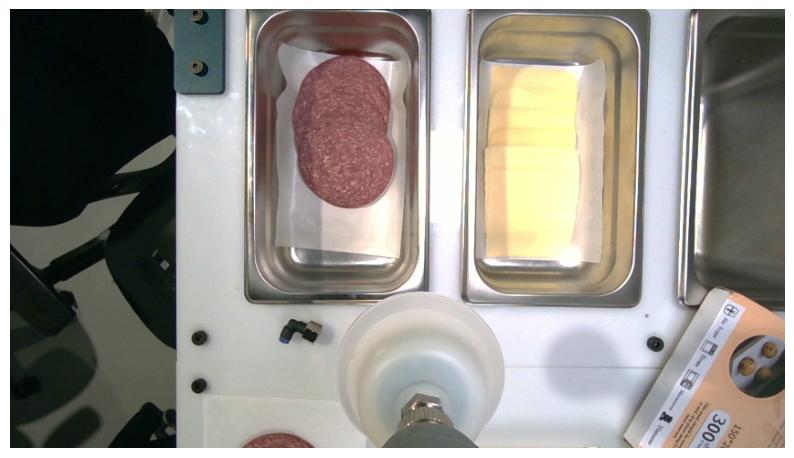

In [196]:
image = Image.open(img_path)
image = np.array(image.convert("RGB"))
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis('off')
plt.show()

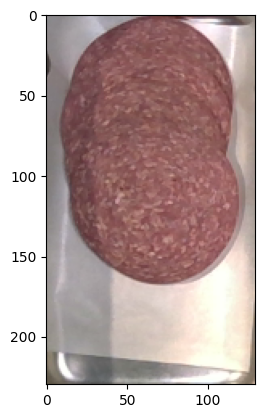

In [197]:
crop_xmin = 300
crop_ymin = 50
crop_xmax = 430
crop_ymax = 280

cropped_image = image[crop_ymin:crop_ymax, crop_xmin:crop_xmax]
plt.imshow(cropped_image)
plt.show()

In [198]:
# crop_xmin_hsv = 320
# crop_ymin_hsv = 180
# crop_xmax_hsv = 390
# crop_ymax_hsv = 300

# cropped2_image = image[crop_ymin_hsv:crop_ymax_hsv, crop_xmin_hsv:crop_xmax_hsv]
# plt.imshow(cropped2_image)
# plt.axis('off')
# plt.show()

# lower_hsv_white, upper_hsv_white = get_hsv_range(cropped2_image)

# print(f"lower_hsv_white: {lower_hsv_white}")
# print(f"upper_hsv_white: {upper_hsv_white}")

In [199]:
# crop_xmin_hsv = 330
# crop_ymin_hsv = 100
# crop_xmax_hsv = 400
# crop_ymax_hsv = 250

# cropped2_image = image[crop_ymin_hsv:crop_ymax_hsv, crop_xmin_hsv:crop_xmax_hsv]
# plt.imshow(cropped2_image)
# plt.axis('off')
# plt.show()

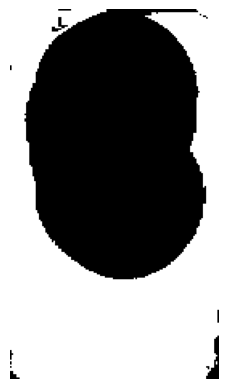

In [201]:
lower_hsv_white = np.array([0,  0, 66])
upper_hsv_white = np.array([176,  53, 255])

white_mask = segment_from_hsv(cropped_image, lower_hsv_white, upper_hsv_white)
not_white_mask = ~white_mask

plt.imshow(white_mask, cmap="gray")
plt.axis("off")
plt.show()


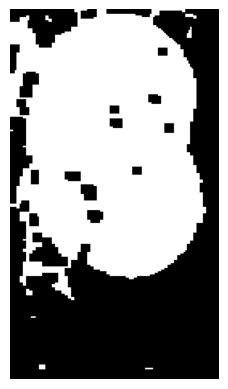

In [202]:
lower_hsv = np.array([116, 7, 85])
upper_hsv = np.array([173, 147, 236])
# lower_hsv, upper_hsv = get_hsv_range(cropped2_image)

hsv_mask = segment_from_hsv(cropped_image, lower_hsv, upper_hsv)


kernel = np.ones((5, 5), np.uint8)  # 5x5 kernel
hsv_mask = cv2.erode(hsv_mask, kernel, iterations=1)
 

plt.imshow(hsv_mask, cmap="gray")
plt.axis("off")
plt.show()

# print(f"lower_hsv: {lower_hsv}")
# print(f"upper_hsv: {upper_hsv}")

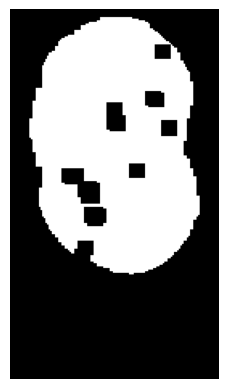

In [ ]:
final_mask = cv2.bitwise_and(hsv_mask, not_white_mask)
kernel = np.ones((5, 5), np.uint8)  # 5x5 kernel
final_mask = cv2.erode(final_mask, kernel, iterations=1)

final_mask = keep_largest_blob(final_mask)

plt.imshow(final_mask, cmap="gray")
plt.axis("off")
plt.show()

In [204]:
bounding_box = calc_bbox_from_mask(final_mask)
bounding_box_w = bounding_box[2] - bounding_box[0]

# Positive point prompt
# positive_pts = [
#     (bounding_box[0] + bounding_box_w//2, bounding_box[1] + 50)
# ]
# point_labels = np.array([1])

# negative_points = [
#     (bounding_box[0]+5, bounding_box[1]+5),  # Top-left
#     (bounding_box[2]-5, bounding_box[1]+5),  # Top-right
#     (bounding_box[0]+5, bounding_box[3]-5),  # Bottom-left
#     (bounding_box[2]-5, bounding_box[3]-5),  # Bottom-right
# ]
# point_labels = np.array([0, 0, 0, 0])  # All are negative prompts

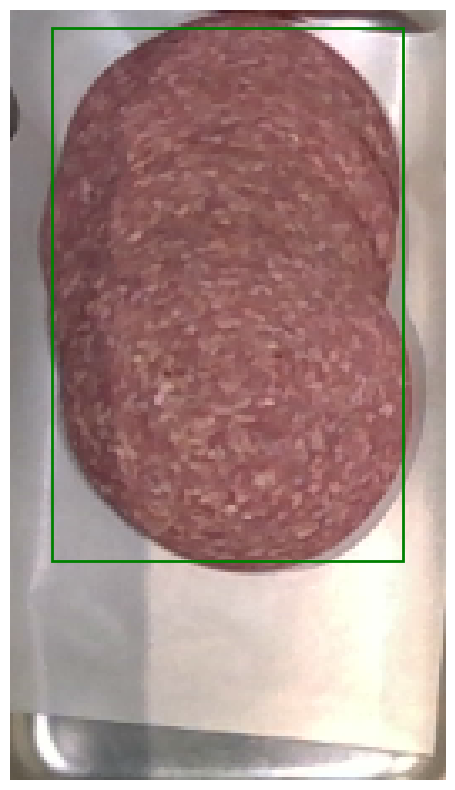

In [205]:
# Create prompt for segmenting all cheese

# bounding_box = np.array([20, 10, 135, 230])
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(cropped_image)
show_box(bounding_box, ax)  # Call function to draw the box
ax.axis("off")  # Hide axes
plt.show()

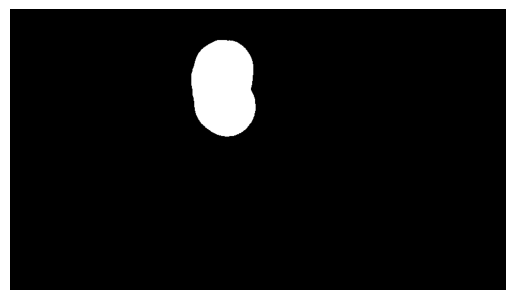

In [206]:
predictor.set_image(cropped_image)
masks, scores, logits = predictor.predict(box=bounding_box[None, :], multimask_output=True)
# masks, scores, logits = predictor.predict(point_coords=negative_points, point_labels=point_labels, box=bounding_box[None, :], multimask_output=True)

sorted_ind = np.argsort(scores)[::-1]
masks = masks[sorted_ind]
scores = scores[sorted_ind]
logits = logits[sorted_ind]

all_meat_mask = masks[np.argmax(scores)]

all_meat_mask_orig = convert_mask_to_orig_dims(all_meat_mask, image, crop_xmin, crop_ymin, crop_xmax, crop_ymax)
plt.imshow(all_meat_mask_orig, cmap="gray")
plt.axis("off")
plt.show()

# show_masks(cropped_image, masks, scores, box_coords=bounding_box, borders=True)


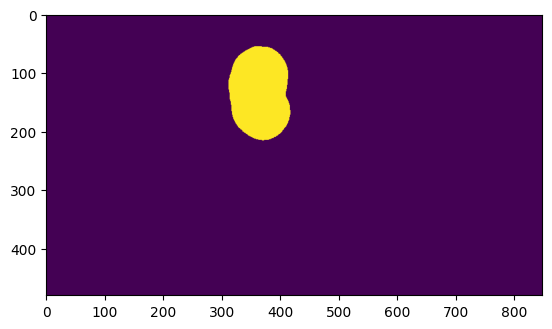

In [207]:
kernel = np.ones((5, 5), np.uint8)  # 5x5 kernel

eroded_mask = cv2.erode(all_meat_mask_orig, kernel, iterations=1)
plt.imshow(eroded_mask)
plt.show()

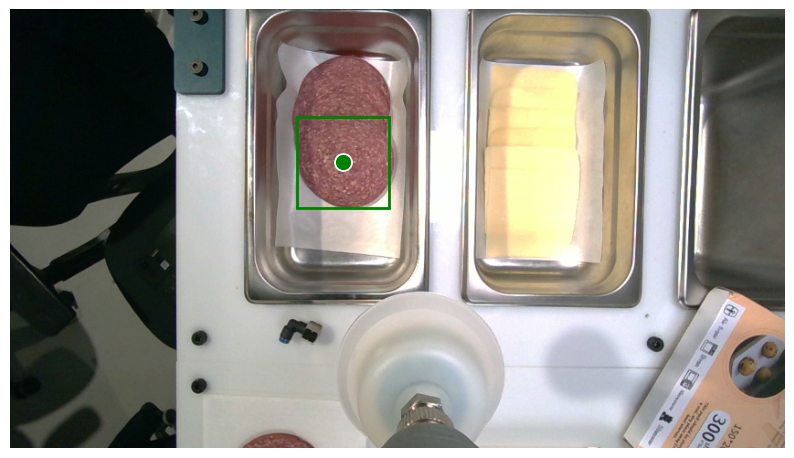

In [208]:
# Cheese dims in pix
meat_w = 100
meat_h = 100
y_indices, x_indices = np.where(all_meat_mask_orig * 255 == 255)

# Ensure there are white pixels
if y_indices.size == 0 or x_indices.size == 0:
    print("No white object found!")

# Find bounding box of the vertical rectangle
xmin, xmax = np.min(x_indices), np.max(x_indices)
ymin, ymax = np.min(y_indices), np.max(y_indices)
# masks = masks[sorted_ind]
# scores = scores[sorted_ind]
# logits = logits[sorted_ind]

# top_meat_mask = masks[np.argmax(scores)]
# kernel = np.ones((5, 5), np.uint8)
# top_meat_mask = cv2.erode(top_meat_mask, kernel, iterations=1)

# plt.imshow(top_meat_mask)

# show_masks(image, masks, scores, borders=True)

meat_bottom_centre_x = (xmin + xmax) // 2
meat_bottom_y = ymax

meat_top_y = ymax - meat_h
meat_right_x = meat_bottom_centre_x + (meat_w // 2)
meat_left_x = meat_bottom_centre_x - (meat_w // 2)


# Design prompts for SAM
meat_box = np.array([meat_left_x, meat_top_y, meat_right_x, meat_bottom_y])

negative_points = [
    (meat_left_x, meat_top_y),  # Top-left
    (meat_right_x, meat_top_y),  # Top-right
    (meat_left_x, meat_bottom_y),  # Bottom-left
    (meat_right_x, meat_bottom_y)   # Bottom-right
]
point_labels = np.array([0, 0, 0, 0])  # All are negative prompts

positive_points = [
    ((meat_left_x + meat_right_x)//2, (meat_top_y + meat_bottom_y)//2),  # Top-left
]
point_labels = np.array([1])

fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(image)
show_box(meat_box, ax)  # Call function to draw the box
# show_points(coords=np.array(negative_points), labels=point_labels, ax=ax)
show_points(coords=np.array(positive_points), labels=point_labels, ax=ax)
ax.axis("off")  # Hide axes
plt.show()

In [86]:
# predictor.set_image(image)
# masks, scores, logits = predictor.predict(box=meat_box[None, :], multimask_output=True)
# masks, scores, logits = predictor.predict(point_coords=negative_points, point_labels=point_labels, box=meat_box[None, :], multimask_output=True)
# masks, scores, logits = predictor.predict(point_coords=positive_points, point_labels=point_labels, multimask_output=True)
# sorted_ind = np.argsort(scores)[::-1]
# masks = masks[sorted_ind]
# scores = scores[sorted_ind]
# logits = logits[sorted_ind]

# top_meat_mask = masks[np.argmax(scores)]
# kernel = np.ones((5, 5), np.uint8)
# top_meat_mask = cv2.erode(top_meat_mask, kernel, iterations=1)

# plt.imshow(top_meat_mask)

# show_masks(image, masks, scores, borders=True)

In [84]:
def segment_top_meat_2e2(img_name, image, lower_hsv, upper_hsv):
    # Crop out the inner borders of the bin
    crop_xmin = 300
    crop_ymin = 50
    crop_xmax = 430
    crop_ymax = 280
    cropped_image = image[crop_ymin:crop_ymax, crop_xmin:crop_xmax]
    
    # Contruct prompt using hsv mask
    mask = segment_from_hsv(cropped_image, lower_hsv, upper_hsv)
    kernel = np.ones((5, 5), np.uint8)
    mask = cv2.erode(mask, kernel, iterations=1)
    # cv2.imwrite(f"{img_name}_hsvmask.jpg", mask)
    bounding_box = calc_bbox_from_mask(mask)

    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(cropped_image)
    show_box(bounding_box, ax)
    ax.axis("off")
    # fig.savefig(f"{img_name}_all_prompt.jpg")

    # meat_right_x, meat_top_y, meat_left_x, meat_bottom_y = bounding_box
    # negative_points = [
    # (meat_left_x, meat_top_y),
    # (meat_right_x, meat_top_y),
    # (meat_left_x, meat_bottom_y),
    # (meat_right_x, meat_bottom_y) 
    # ]
    # point_labels = np.array([0, 0, 0, 0])

    # Run SAM
    predictor.set_image(cropped_image)
    masks, scores, logits = predictor.predict(box=bounding_box[None, :], multimask_output=True)
    sorted_ind = np.argsort(scores)[::-1]
    masks = masks[sorted_ind]
    scores = scores[sorted_ind]
    logits = logits[sorted_ind]
    all_meat_mask = masks[np.argmax(scores)]

    # Process mask from SAM
    all_meat_mask_orig = convert_mask_to_orig_dims(all_meat_mask, image, crop_xmin, crop_ymin, crop_xmax, crop_ymax)
    kernel = np.ones((5, 5), np.uint8)
    all_meat_mask_orig = cv2.erode(all_meat_mask_orig, kernel, iterations=1)

    meat_w = 100
    meat_h = 100
    y_indices, x_indices = np.where(all_meat_mask_orig * 255 == 255)

    # Ensure there are white pixels
    if y_indices.size == 0 or x_indices.size == 0:
        print("No white object found!")

    # Find bounding box of the vertical rectangle
    xmin, xmax = np.min(x_indices), np.max(x_indices)
    ymin, ymax = np.min(y_indices), np.max(y_indices)
    meat_bottom_centre_x = (xmin + xmax) // 2
    meat_bottom_y = ymax
    meat_top_y = ymax - meat_h
    meat_right_x = meat_bottom_centre_x + (meat_w // 2)
    meat_left_x = meat_bottom_centre_x - (meat_w // 2)
    meat_box = np.array([meat_left_x, meat_top_y, meat_right_x, meat_bottom_y])

    negative_points = [
        (meat_left_x, meat_top_y),  # Top-left
        (meat_right_x, meat_top_y),  # Top-right
        (meat_left_x, meat_bottom_y),  # Bottom-left
        (meat_right_x, meat_bottom_y)   # Bottom-right
    ]
    point_labels = np.array([0, 0, 0, 0])

    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(image)
    show_box(meat_box, ax)  # Call function to draw the box
    show_points(coords=np.array(negative_points), labels=point_labels, ax=ax)
    ax.axis("off")  # Hide axes
    # fig.savefig(f"{img_name}_top_prompt.jpg")
    
    # Run SAM on top meat box
    predictor.set_image(image)
    masks, scores, logits = predictor.predict(point_coords=negative_points, point_labels=point_labels, box=meat_box[None, :], multimask_output=True)
    sorted_ind = np.argsort(scores)[::-1]
    masks = masks[sorted_ind]
    scores = scores[sorted_ind]
    logits = logits[sorted_ind]
    top_meat_mask = masks[np.argmax(scores)]
    kernel = np.ones((5, 5), np.uint8)
    top_meat_mask = cv2.erode(top_meat_mask, kernel, iterations=1)

    return top_meat_mask

In [85]:
def test_on_dir(dir_path):
    # Sample the bin for getting hsv range dynamically

    first_img = True
    lower_hsv = None
    upper_hsv = None

    crop_xmin_hsv = 320
    crop_ymin_hsv = 100
    crop_xmax_hsv = 390
    crop_ymax_hsv = 250

    image_names = sorted(os.listdir(dir_path))

    for img_name in image_names:

        img_path = os.path.join(dir_path, img_name)
        image = Image.open(img_path)
        image = np.array(image.convert("RGB"))

        if first_img:
            first_img = False
            cropped2_image = image[crop_ymin_hsv:crop_ymax_hsv, crop_xmin_hsv:crop_xmax_hsv]
            # cv2.imwrite("fist_image.jpg", image)
            # cv2.imwrite("fist_image_hsv_crop.jpg", cropped2_image)
            # break
            lower_hsv, upper_hsv = get_hsv_range(cropped2_image)
            print(f"lower_hsv: {lower_hsv}")
            print(f"upper_hsv: {upper_hsv}")

        top_meat_mask = segment_top_meat_2e2(img_name, image, lower_hsv, upper_hsv)
        top_meat_mask *= 255

        color = (0, 0, 255)
        colored_image = np.zeros_like(image)
        colored_image[:] = color
        result = np.where(top_meat_mask[:, :, None] == 255, colored_image, image)
        result = cv2.cvtColor(result, cv2.COLOR_RGB2BGR)
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        
        stitched_image = np.hstack((image, result))

        # cv2.imwrite(f"{img_name.split('.')[0]}_result.jpg", result)
        cv2.imwrite(f"{img_name.split('.')[0]}_result.jpg", stitched_image)


In [219]:
def segment_top_meat_2e2_new(img_name, image, lower_hsv, upper_hsv, lower_hsv_white, upper_hsv_white):
    # Crop out the inner borders of the bin
    crop_xmin = 300
    crop_ymin = 50
    crop_xmax = 430
    crop_ymax = 280
    cropped_image = image[crop_ymin:crop_ymax, crop_xmin:crop_xmax]

    # Mask to remove noise
    white_mask = segment_from_hsv(cropped_image, lower_hsv_white, upper_hsv_white)
    not_white_mask = ~white_mask
    # plt.imshow(white_mask, cmap="gray")
    # plt.axis("off")
    # plt.show()

    # Get HSV Mask
    hsv_mask = segment_from_hsv(cropped_image, lower_hsv, upper_hsv)
    kernel = np.ones((5, 5), np.uint8)
    hsv_mask = cv2.erode(hsv_mask, kernel, iterations=1)
    # plt.imshow(hsv_mask, cmap="gray")
    # plt.axis("off")
    # plt.show()

    # Remove noise from hsv mask
    final_mask = cv2.bitwise_and(hsv_mask, not_white_mask)
    kernel = np.ones((5, 5), np.uint8)
    final_mask = cv2.erode(final_mask, kernel, iterations=1)
    final_mask = keep_largest_blob(final_mask)
    # plt.imshow(final_mask, cmap="gray")
    # plt.axis("off")
    # plt.show()

    # Create prompt for bbox
    bounding_box = calc_bbox_from_mask(final_mask)
    # fig, ax = plt.subplots(figsize=(10, 10))
    # ax.imshow(final_mask)
    # show_box(bounding_box, ax)
    # ax.axis("off")  # Hide axes
    # plt.show()

    # fig, ax = plt.subplots(figsize=(10, 10))
    # ax.imshow(cropped_image)
    # show_box(bounding_box, ax)
    # ax.axis("off")  # Hide axes
    # plt.show()

    # Run SAM
    predictor.set_image(cropped_image)
    masks, scores, logits = predictor.predict(box=bounding_box[None, :], multimask_output=True)
    sorted_ind = np.argsort(scores)[::-1]
    masks = masks[sorted_ind]
    scores = scores[sorted_ind]
    logits = logits[sorted_ind]
    all_meat_mask = masks[np.argmax(scores)]

    # Process mask from SAM
    all_meat_mask_orig = convert_mask_to_orig_dims(all_meat_mask, image, crop_xmin, crop_ymin, crop_xmax, crop_ymax)
    kernel = np.ones((5, 5), np.uint8)
    all_meat_mask_orig = cv2.erode(all_meat_mask_orig, kernel, iterations=1)
    # plt.imshow(all_meat_mask_orig, cmap="gray")
    # plt.axis("off")
    # plt.show()

    y_indices, x_indices = np.where(all_meat_mask_orig * 255 == 255)

    # Ensure there are white pixels
    if y_indices.size == 0 or x_indices.size == 0:
        print("No white object found!")

    # Find bounding box of the vertical rectangle
    xmin, xmax = np.min(x_indices), np.max(x_indices)
    ymin, ymax = np.min(y_indices), np.max(y_indices)

    # Find coordinates of top meat box
    meat_w = 100
    meat_h = 100
    meat_bottom_centre_x = (xmin + xmax) // 2
    meat_bottom_y = ymax
    meat_top_y = ymax - meat_h
    meat_right_x = meat_bottom_centre_x + (meat_w // 2)
    meat_left_x = meat_bottom_centre_x - (meat_w // 2)
    meat_box = np.array([meat_left_x, meat_top_y, meat_right_x, meat_bottom_y])

    positive_points = [
        ((meat_left_x + meat_right_x)//2, (meat_top_y + meat_bottom_y)//2),  # Top-left
    ]
    point_labels = np.array([1])
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(image)
    show_box(meat_box, ax)
    show_points(coords=np.array(positive_points), labels=point_labels, ax=ax)
    ax.axis("off")
    fig.savefig(f"{img_name}_result.jpg")
    plt.show()
    

In [ ]:
def test_on_dir_new(dir_path):
    # Sample the bin for getting hsv range dynamically

    first_img = True
    lower_hsv = None
    upper_hsv = None

    crop_xmin_hsv = 330
    crop_ymin_hsv = 100
    crop_xmax_hsv = 400
    crop_ymax_hsv = 250

    lower_hsv_white = np.array([0,  0, 66])
    upper_hsv_white = np.array([176,  53, 255])

    image_names = sorted(os.listdir(dir_path))

    for img_name in image_names:

        img_path = os.path.join(dir_path, img_name)
        image = cv2.imread(img_path)

        if first_img:
            first_img = False
            cropped2_image = image[crop_ymin_hsv:crop_ymax_hsv, crop_xmin_hsv:crop_xmax_hsv]
            # cv2.imwrite("fist_image.jpg", image)
            # cv2.imwrite("fist_image_hsv_crop.jpg", cropped2_image)

            lower_hsv, upper_hsv = get_hsv_range(cropped2_image)

        segment_top_meat_2e2_new(img_name, image, lower_hsv, upper_hsv, lower_hsv_white, upper_hsv_white)


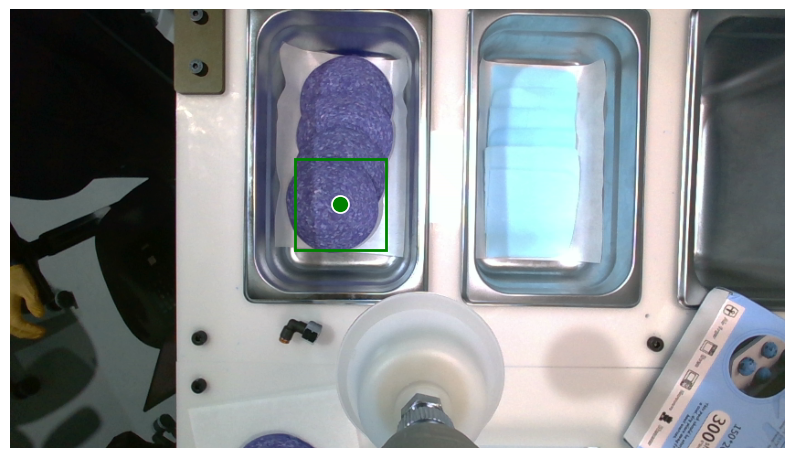

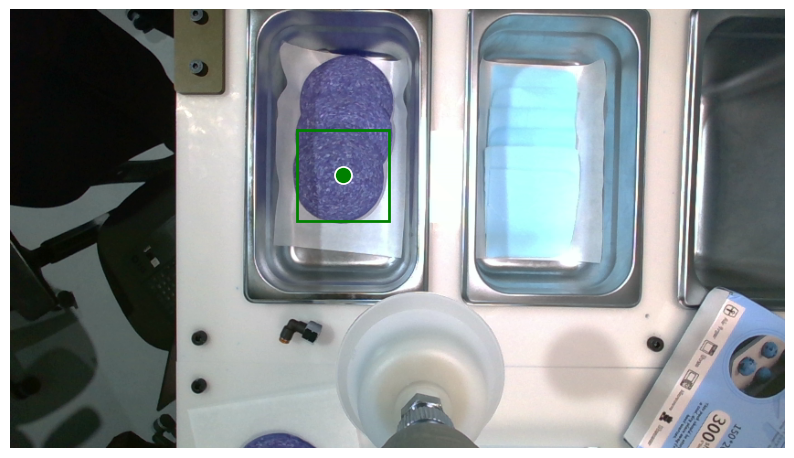

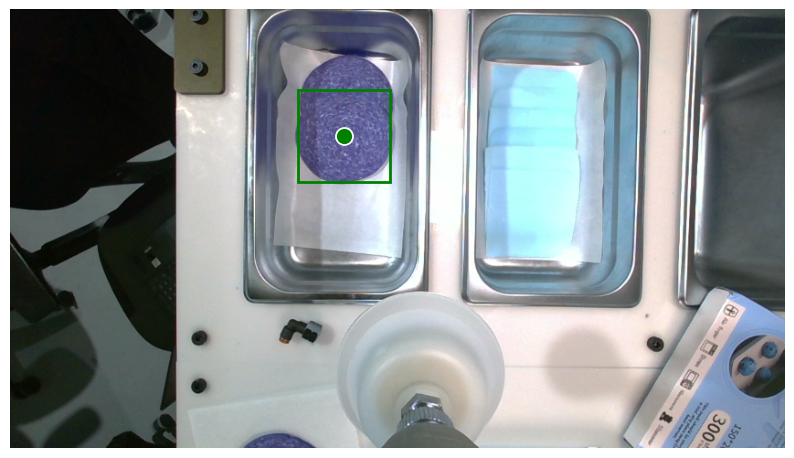

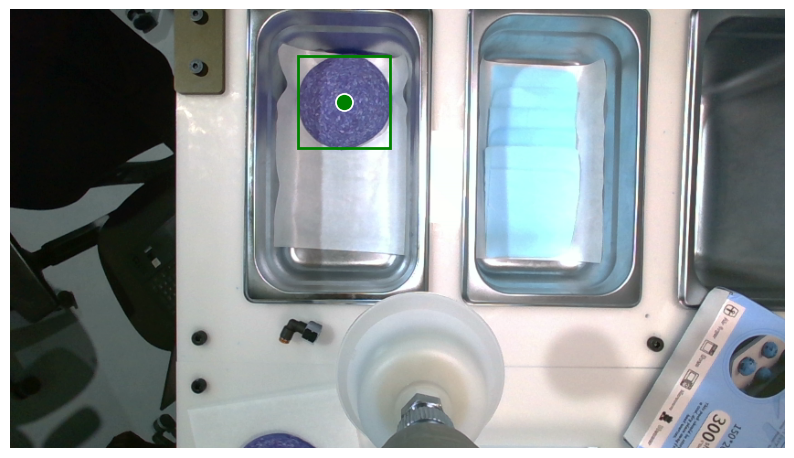

In [224]:
test_on_dir_new("/home/user/data_collection/pr3_test/BAL_images_031925_3")